# Data Collection
---
## Web scraping
To collect the data, I'm scrapping the data from Skytrax: [https://www.airlinequality.com/airline-reviews/british-airways]. Using `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import LdaModel, CoherenceModel
import requests
import nltk
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gensim


In [2]:
def parse_review(review):
    title = review.find('h2', class_='text_header').text.strip()
    author_name_tag = review.find('span', itemprop='name')
    author_location = author_name_tag.find_parent().next_sibling.strip()
    date_published = review.find('time', itemprop='datePublished').text.strip()
    review_body = review.find('div', class_='text_content').text.strip()

    # Extract ratings if available
    ratings = {}
    ratings_table = review.find('table', class_='review-ratings')
    if ratings_table:
        rows = ratings_table.find_all('tr')
        for row in rows:
            rating_category = row.find('td', class_='review-rating-header').text.strip()

            # Special handling for star ratings
            if row.find('td', class_='review-rating-stars stars'):
                star_rating = len(row.find_all('span', class_='star fill'))
                ratings[rating_category] = star_rating
            else:
                rating_value = row.find('td', class_='review-value').text.strip()
                ratings[rating_category] = rating_value

    return {
        "Title": title,
        "Author Location": author_location,
        "Date Published": date_published,
        "Review Body": review_body,
        "Ratings": ratings
    }

# Function to scrape reviews from a given page
def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = soup.find_all('div', class_='body')

    review_data = []
    for review in reviews:
        parsed_review = parse_review(review)
        review_data.append(parsed_review)

    return review_data

# Function to scrape multiple pages
def scrape_multiple_pages(base_url, start_page=1, end_page=5):
    all_reviews = []
    for page_num in range(start_page, end_page + 1):
        page_url = f"{base_url}/page/{page_num}/"
        print(f"Scraping {page_url}")
        reviews = scrape_page(page_url)
        all_reviews.extend(reviews)

    return all_reviews


base_url = 'https://www.airlinequality.com/airline-reviews/british-airways'


start_page = 1
end_page = 100 

# Scrape reviews
all_reviews = scrape_multiple_pages(base_url, start_page=start_page, end_page=end_page)

# Convert the list of reviews into a DataFrame
reviews_df = pd.DataFrame(all_reviews)

# Expand the 'Ratings' dictionary into separate columns (if needed)
ratings_df = reviews_df['Ratings'].apply(pd.Series)
reviews_df = pd.concat([reviews_df.drop('Ratings', axis=1), ratings_df], axis=1)

# Display the DataFrame
reviews_df.head()

Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/1/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/2/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/3/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/4/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/5/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/6/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/7/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/8/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/9/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/10/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/11/
Scraping https://www.airlinequality.com/airline-reviews/british-airways/page/12/
Scraping https://www.airlinequality.c

,Title,Author Location,Date Published,Review Body,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Route,Wifi & Connectivity,Aircraft,Food & Beverages,Inflight Entertainment
0,"""zero response from BA to reimburse us""",(United States),18th August 2024,Not Verified | The customer service is one of...,Family Leisure,Economy Class,July 2024,1.0,1.0,1.0,1,no,NaN,NaN,NaN,NaN,NaN
1,"""no acknowledgment or resolution""",(United Kingdom),15th August 2024,"Not Verified | Before my flight, I was forced ...",Solo Leisure,Economy Class,June 2024,1.0,1.0,1.0,1,no,London to Basel,1.0,NaN,NaN,NaN
2,"""Outstanding service""",(United Kingdom),12th August 2024,✅ Trip Verified | British Airways at its bes...,Solo Leisure,Business Class,July 2024,5.0,5.0,4.0,4,yes,Vancouver to London,NaN,A350,5.0,5.0
3,"""the crew were fabulous""",(Lebanon),12th August 2024,✅ Trip Verified | An excellent flight! Despite...,Solo Leisure,Economy Class,August 2024,3.0,5.0,4.0,4,yes,London to Amman,NaN,A320,4.0,NaN
4,“customer service has been horrible”,(United States),11th August 2024,✅ Trip Verified | I recently traveled with Bri...,Family Leisure,Economy Class,August 2024,3.0,4.0,2.0,3,no,Barcelona to Dallas via Heathrow,NaN,A380,4.0,4.0


In [3]:
reviews_df.to_csv("data/BA_reviews.csv")

# Data Cleaning
---
## Steps
1. Handling missing Values
2. Remove Non-textual elements
3. Text Normalization
4. Convert date columns
5. Convert 'Recommended' column to binary values

In [4]:
def clean_text_simple(text):
    # First, remove "Trip Verified" and "Not Verified" regardless of their case
    text = text.replace("Trip Verified", "").replace("Not Verified", "")
    # Then continue with other cleaning steps
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.lower()
    text = re.sub(r'\d+', '', text) 
    text = text.strip()
    return text

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   1000 non-null   object 
 1   Author Location         1000 non-null   object 
 2   Date Published          1000 non-null   object 
 3   Review Body             1000 non-null   object 
 4   Type Of Traveller       998 non-null    object 
 5   Seat Type               1000 non-null   object 
 6   Date Flown              1000 non-null   object 
 7   Seat Comfort            912 non-null    float64
 8   Cabin Staff Service     903 non-null    float64
 9   Ground Service          943 non-null    float64
 10  Value For Money         1000 non-null   int64  
 11  Recommended             1000 non-null   object 
 12  Route                   996 non-null    object 
 13  Wifi & Connectivity     319 non-null    float64
 14  Aircraft                533 non-null    o

In [6]:
#drop aircraft and wifi & connectivity columns
data_cleaned = reviews_df.drop(columns=['Wifi & Connectivity'])

# Convert Date to datetime format
data_cleaned['Date Published'] = pd.to_datetime(data_cleaned['Date Published'], errors='coerce')

# Convert Recommended to binary format
data_cleaned['Recommended'] = data_cleaned['Recommended'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# remove any unnecessary text
data_cleaned['Review Body'] = data_cleaned['Review Body'].apply(clean_text_simple)
data_cleaned['Author Location'] = data_cleaned['Author Location'].apply(clean_text_simple)
data_cleaned['Title'] = data_cleaned['Title'].apply(clean_text_simple)

data_cleaned.head()


,Title,Author Location,Date Published,Review Body,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Route,Aircraft,Food & Beverages,Inflight Entertainment
0,zero response from ba to reimburse us,united states,2024-08-18,the customer service is one of the worst i hav...,Family Leisure,Economy Class,July 2024,1.0,1.0,1.0,1,0,NaN,NaN,NaN,NaN
1,no acknowledgment or resolution,united kingdom,2024-08-15,before my flight i was forced by the ground st...,Solo Leisure,Economy Class,June 2024,1.0,1.0,1.0,1,0,London to Basel,NaN,NaN,NaN
2,outstanding service,united kingdom,2024-08-12,british airways at its best outstanding servic...,Solo Leisure,Business Class,July 2024,5.0,5.0,4.0,4,1,Vancouver to London,A350,5.0,5.0
3,the crew were fabulous,lebanon,2024-08-12,an excellent flight despite this being a hour...,Solo Leisure,Economy Class,August 2024,3.0,5.0,4.0,4,1,London to Amman,A320,4.0,NaN
4,customer service has been horrible,united states,2024-08-11,i recently traveled with british airways and h...,Family Leisure,Economy Class,August 2024,3.0,4.0,2.0,3,0,Barcelona to Dallas via Heathrow,A380,4.0,4.0


# EDA (Exploratory Data Analysis)
---
##1. Ratio of positive and negative reviews

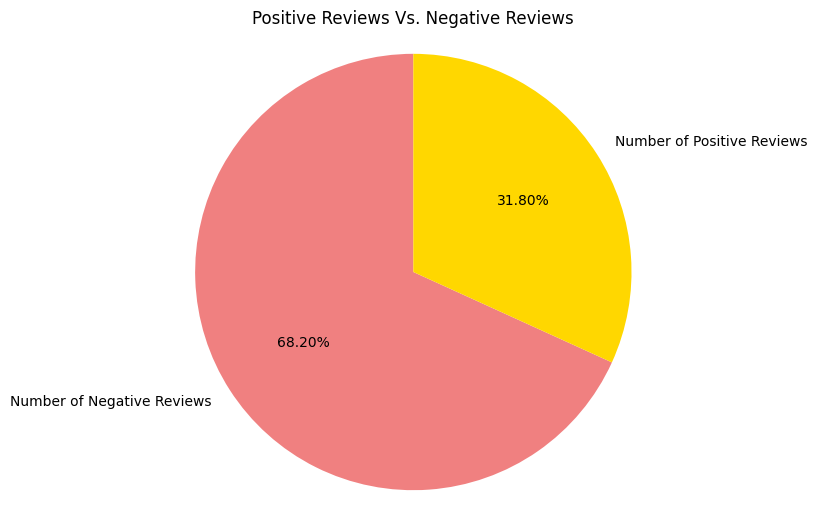

In [7]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(data_cleaned[data_cleaned['Recommended'] == 0]), len(data_cleaned[data_cleaned['Recommended'] == 1])]

ax.pie(values, 
       labels = ['Number of Negative Reviews', 'Number of Positive Reviews'], 
       colors=['lightcoral', 'gold'],
       shadow=False,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews')
plt.show()

##2. Box plot of ratings for different aspects

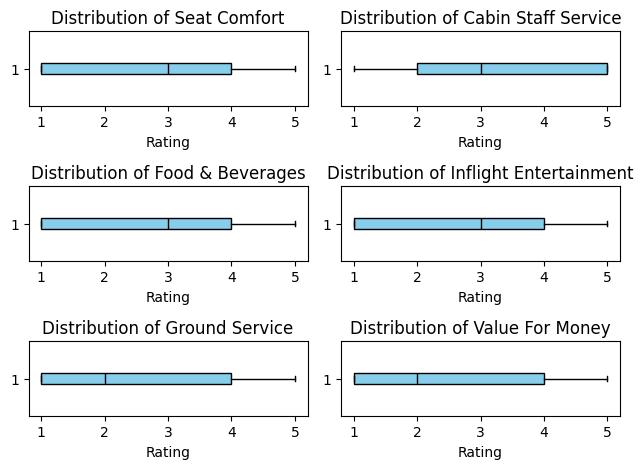

In [8]:
rating_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
                  'Inflight Entertainment', 'Ground Service', 'Value For Money']
fig, axes = plt.subplots(nrows=3, ncols=2)
axes = axes.flatten()

for i, col in enumerate(rating_columns):
    axes[i].boxplot(data_cleaned[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Rating')

plt.tight_layout()
plt.show()

###Observations:
- The median ratings for most aspects of the service hover around 3, indicating that passengers generally perceive the service as average.
- Ground Service and Value For Money show medians around 2, indicating room for improvement in these areas.


In [9]:
reviews_by_country = data_cleaned['Author Location'].value_counts()
print("Reviewers came from " + str(len(reviews_by_country)) + " different countries")
print("Here are the top 10 countries by the number of reviews:")
reviews_by_country.head(10)


Reviewers came from 56 different countries
Here are the top 10 countries by the number of reviews:


Author Location
united kingdom          564
united states           168
canada                   37
australia                35
germany                  17
south africa             16
ireland                  10
united arab emirates     10
italy                    10
switzerland               9
Name: count, dtype: int64

##3. Violin plot of overall ratings by country (top 10 countries)

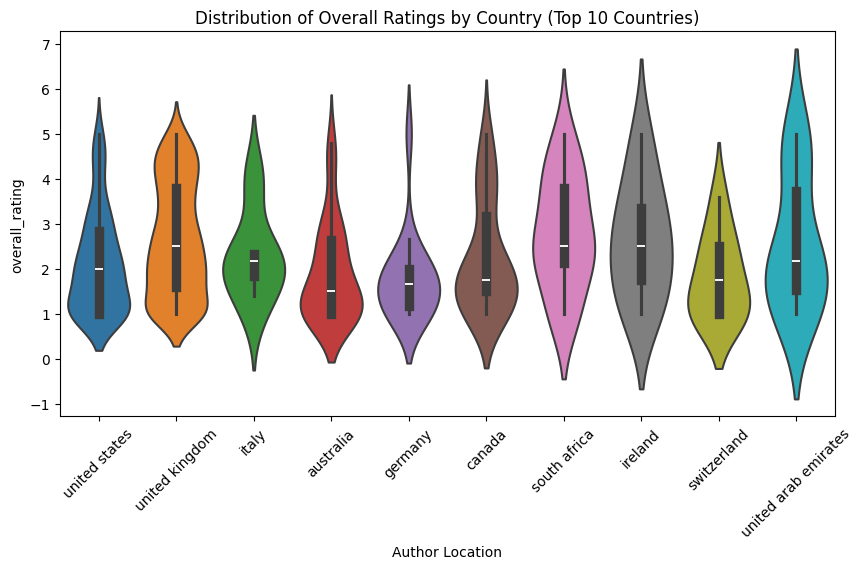

In [10]:
# Get the top 10 countries by the number of reviews
top_10_countries = reviews_by_country.head(10).index

# Filter the data to include only the top 10 countries
top_10_data = data_cleaned[data_cleaned['Author Location'].isin(top_10_countries)]

# Select the columns of interest
columns_of_interest = ['Author Location', 'Seat Comfort', 'Cabin Staff Service', 
                       'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 
                       'Value For Money']

# Create a new column "overall_rating" that calculates the average rating across the selected columns
data_cleaned['overall_rating'] = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                                               'Food & Beverages', 'Inflight Entertainment', 
                                               'Ground Service', 'Value For Money']].mean(axis=1)


# Plot the violin plot for the top 10 countries using the overall_rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Author Location', y='overall_rating', hue='Author Location',
               data=data_cleaned[data_cleaned['Author Location'].isin(top_10_countries)], 
               inner="box", linewidth=1.5) 
plt.xticks(rotation=45)
plt.title('Distribution of Overall Ratings by Country (Top 10 Countries)')
plt.show()

###Observations
Median Ratings:

- The median rating (the white dot) for most countries is around 2 to 3, indicating a central tendency towards slightly below-average to average ratings.
- Ireland appears to have a slightly higher median rating, suggesting a generally better perception of service.

Rating Spread:

- United Kingdom and United Arab Emirates show a wide spread of ratings, indicating a significant variation in experiences.
- Italy and Germany have a more concentrated distribution, suggesting more consistent ratings from authors in these countries.

Outliers and Extremes:

- There are some outliers or extreme ratings visible in the distributions, particularly in United States and Canada, where there are occasional very low or very high ratings.

In [11]:
# Calculate review counts (number of non-null entries) for each rating category
review_counts = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                              'Food & Beverages', 'Inflight Entertainment', 
                              'Ground Service', 'Value For Money']].count()

# Calculate the average rating for each category
average_ratings = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                                'Food & Beverages', 'Inflight Entertainment', 
                                'Ground Service', 'Value For Money']].mean()

# Create a summary DataFrame to display review counts and average ratings
summary_df = pd.DataFrame({
    'Review Count': review_counts,
    'Average Rating': average_ratings
})
print(summary_df)

                        Review Count  Average Rating
Seat Comfort                     912        2.713816
Cabin Staff Service              903        3.128461
Food & Beverages                 779        2.654685
Inflight Entertainment           515        2.772816
Ground Service                   943        2.519618
Value For Money                 1000        2.340000


#Text Analytics
---
##1. WordClouds

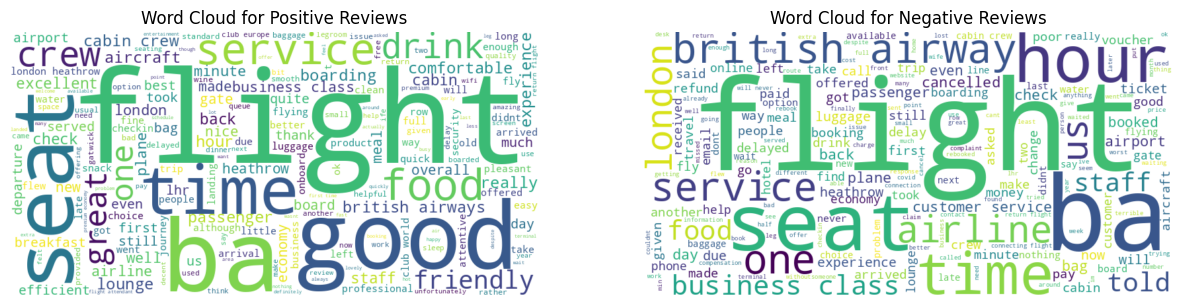

In [12]:
positive_reviews = data_cleaned[data_cleaned['Recommended'] == 1]['Review Body']
negative_reviews = data_cleaned[data_cleaned['Recommended'] == 0]['Review Body']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Concatenate all the review texts
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

###Oberservations
Positive Reviews:
- Prominent Words: The most prominent words in the positive reviews include "flight," "good," "service," "great," "seat," "time," "food," and "friendly."
- Positive Sentiments: Words like "great," "good," "friendly," and "excellent" suggest that customers who recommended the service had positive experiences, particularly regarding the overall flight experience, seating, service, and food.
- Brand Mention: "BA" and "British Airways" appear frequently, which is expected as customers often mention the airline directly in their positive feedback.

Negative Reviews:
- Prominent Words: In the negative reviews, the most prominent words include "flight," "hour," "time," "seat," "service," "BA," "airline," and "staff."
- Negative Sentiments: Words like "cancelled," "delayed," "told," "help," and "poor" suggest dissatisfaction, particularly regarding time management (e.g., delays), customer service, and overall service quality.
- Focus on Issues: The frequent mention of "hour" and "time" may indicate that timing (such as delays or long waits) was a significant issue for those who did not recommend the service.

Comparative Insights:
- Common Themes: Both word clouds prominently feature "flight" and "seat," indicating that these are central aspects of the customer experience, whether positive or negative.
- Differences in Sentiment: The positive word cloud emphasizes words related to satisfaction and comfort ("good," "great," "friendly"), whereas the negative word cloud highlights frustration points ("cancelled," "delayed," "poor").

Actionable Insights:
- Focus on Time Management: Given the frequent mention of "time" and "hour" in negative reviews, improving punctuality and handling delays could significantly enhance customer satisfaction.
- Service Quality: The appearance of "service" in both clouds suggests that while some customers praise it, others find it lacking. Focusing on consistent service quality across all flights could help convert neutral or negative experiences into positive ones.

##2. Sensitivity analysis

In [27]:
# Function to classify sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis
data_cleaned['Sentiment'] = data_cleaned['Review Body'].apply(get_sentiment)

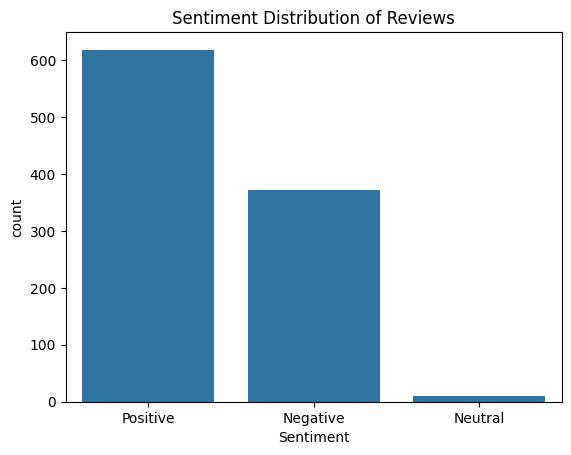

In [14]:
sns.countplot(data=data_cleaned, x='Sentiment')
plt.title('Sentiment Distribution of Reviews')
plt.show()

In [15]:
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

data_cleaned['Subjectivity'] = data_cleaned['Review Body'].apply(subjectivity)
data_cleaned['Polarity'] = data_cleaned['Review Body'].apply(polarity)

In [16]:

fig = px.scatter(data_cleaned, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color='Sentiment',
                 size='Subjectivity')  
# Add a vertical line at x=0 for Neutral Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type='line',
                               yref='paper', y0=0, y1=1, 
                               xref='x', x0=0, x1=0)],
                  xaxis_title='Polarity',
                  yaxis_title='Subjectivity')

fig.show()

###Observations

- The plot shows a clear distinction between positive and negative sentiments based on polarity, with neutral sentiments clustered around zero polarity.
- Negative sentiments tend to be more subjective compared to positive sentiments.
- Positive reviews tend to be more evenly distributed across different levels of subjectivity, while negative reviews show more variation in subjectivity.
- This visualization highlights the general trend that more opinionated reviews are often either highly positive or highly negative, with fewer being neutral.

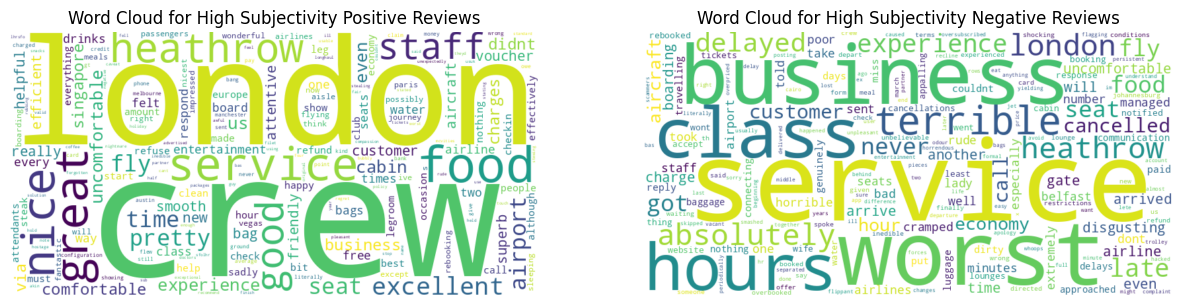

In [17]:
# Filter reviews with high subjectivity
high_subjectivity_reviews = data_cleaned[data_cleaned['Subjectivity'] > 0.7]
# Separate the high subjectivity reviews into positive and negative
positive_high_subjectivity = high_subjectivity_reviews[high_subjectivity_reviews['Sentiment'] == 'Positive']
negative_high_subjectivity = high_subjectivity_reviews[high_subjectivity_reviews['Sentiment'] == 'Negative']

stopwords = set(STOPWORDS)
custom_stopwords = {"ba", "british", "airways", "flight", "flights"} 
stopwords = stopwords.union(custom_stopwords)

def clean_and_split(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    words = text.split()
    words = [word for word in words if word not in stopwords]  
    return words

# Get word frequencies for positive and negative high subjectivity reviews
positive_words = positive_high_subjectivity['Review Body'].apply(clean_and_split).sum()
negative_words = negative_high_subjectivity['Review Body'].apply(clean_and_split).sum()
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_freq)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_word_freq)

# Plot the word clouds side by side
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Subjectivity Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Subjectivity Negative Reviews')

plt.show()

###Obeservations
High Subjectivity Positive Reviews (Left Word Cloud):
- "Crew" and "Service": These are among the most prominent words, indicating that customers who leave highly subjective positive reviews frequently mention the airline's crew and the quality of service. This suggests that the crew's performance and overall service are significant factors in positive experiences.
- "London": The frequent mention of "London" could indicate that many positive experiences are associated with flights to or from London, or that London-based flights tend to be more positively reviewed.
- "Heathrow": Similar to "London," "Heathrow" appears prominently, suggesting that experiences related to this airport are often positive. It could be due to the facilities, the efficiency of the airport, or the quality of service received on flights passing through Heathrow.
- "Comfortable," "Attentive," "Helpful": These words indicate specific aspects of the service that customers appreciate, particularly the comfort of the seating and the attentiveness of the crew.

High Subjectivity Negative Reviews (Right Word Cloud):
- "Business" and "Class": The frequent mention of "business class" suggests that there might be specific issues related to the business class experience, such as unmet expectations or perceived poor value for the premium price.
- "Delayed" and "Cancelled": These words indicate that delays and cancellations are common issues driving negative sentiment, reflecting frustration with the airline's time management.
- "Arrived," "Hour," "Gate": These terms suggest issues with timing and airport experiences, such as long waits at gates, late arrivals, and extended flight durations, all contributing to negative experiences.

Actionable Insights:

- Enhancing Positive Aspects:

    - Crew and Service: Since these are central to positive experiences, continuing to invest in crew training and maintaining high service standards can help retain customer satisf

- Addressing Negative Feedback:

    - Service Consistency: Since service is also a major pain point in negative reviews, efforts should be made to ensure consistency in service quality across all flights.
    - Business Class Experience: Investigate specific complaints related to business class, as it appears to be a source of significant dissatisfaction. Enhancing the business class experience could improve overall sentiment.
    - Operational Efficiency: Addressing issues related to delays, cancellations, and overall punctuality could reduce negative sentiment, particularly in relation to timing and gate management.

In [18]:
# Example key words to track
keywords = ['service', 'delayed', 'crew', 'comfort', 'business', 'cancellation']
sentiment_trends = {}
for word in keywords:
    # Filter reviews containing the word
    keyword_reviews = data_cleaned[data_cleaned['Review Body'].str.contains(word, case=False, na=False)]
    
    # Group by date and compute average polarity
    keyword_trend = keyword_reviews.groupby(data_cleaned['Date Published'].dt.to_period("M"))['Polarity'].mean()
    
    # Store the trend
    sentiment_trends[word] = keyword_trend

# Convert to DataFrame for easier plotting
sentiment_trends_df = pd.DataFrame(sentiment_trends)


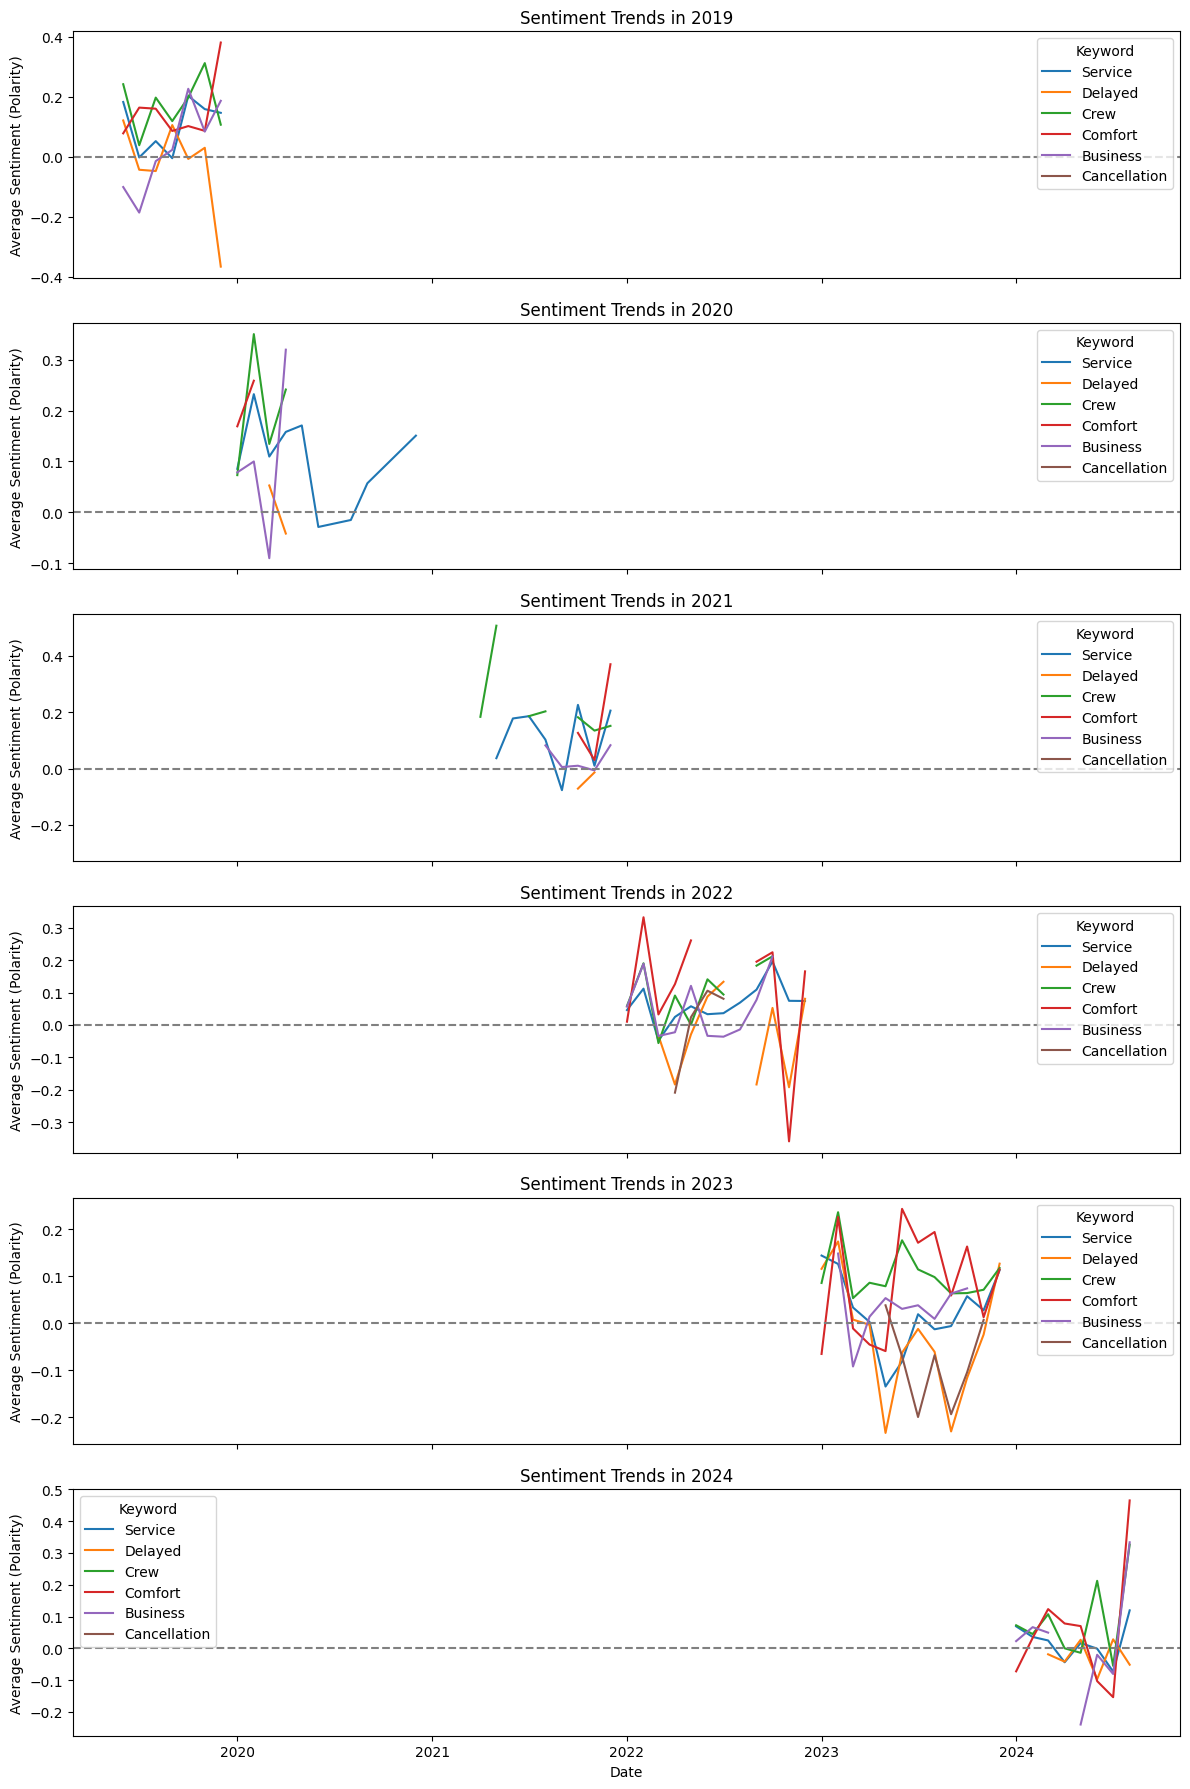

In [26]:
years = sentiment_trends_df.index.year.unique()

# Create subplots, one for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, len(years) * 3), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    
    # Filter the data for the current year
    year_data = sentiment_trends_df[sentiment_trends_df.index.year == year]
    
    for word in keywords:
        ax.plot(year_data.index.to_timestamp(), year_data[word], label=word.capitalize())
    
    ax.set_title(f'Sentiment Trends in {year}')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylabel('Average Sentiment (Polarity)')
    if i == len(years) - 1:
        ax.set_xlabel('Date')
    ax.legend(title='Keyword')

plt.tight_layout()
plt.show()

##3. LDA Topic Modeling

In [20]:

def preprocess_text(text):
    # Tokenize and remove punctuation
    tokens = simple_preprocess(text, deacc=True)
    
    # # Load NLTK stopwords
    # nltk_stop_words = set(stopwords.words('english'))
    
    # # Add custom stopwords
    # custom_stopwords = {"ba", "british", "airways", "flight", "flights"}
    
    # Combine NLTK stopwords with custom stopwords
    # combined_stop_words = nltk_stop_words.union(custom_stopwords)
    
    # Remove stopwords from tokens
    tokens = [word for word in tokens if word not in stopwords]
    
    return tokens

# Apply the preprocessing function to the 'Review Body' column
data_cleaned['Processed'] = data_cleaned['Review Body'].apply(preprocess_text)

# Create a dictionary representation of the documents.
dictionary = Dictionary(data_cleaned['Processed'])

# Filter out extremes (very common and very rare words)
dictionary.filter_extremes(no_below=15, no_above=0.9)

# Convert the dictionary into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in data_cleaned['Processed']]

In [21]:
num_topics_range = range(5, 21, 5)
perplexity_values = []
coherence_values = []

# Loop over the range and train a model for each number of topics
for num_topics in num_topics_range:
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    
    # Evaluate Perplexity
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)
    print(f'Perplexity for {num_topics} topics: {perplexity}')
    
    # Evaluate Coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_cleaned['Processed'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print(f'Coherence Score for {num_topics} topics: {coherence_lda}')

    # Print the topics for the current model
    print(f"\nTopics for {num_topics} topics:")
    topics = lda_model.print_topics(num_words=15)
    for topic in topics:
        print(topic)





Training LDA model with 5 topics...
Perplexity for 5 topics: -6.319565802631956
Coherence Score for 5 topics: 0.35864277941115386

Topics for 5 topics:
(0, '0.025*"service" + 0.021*"customer" + 0.019*"london" + 0.010*"airline" + 0.010*"heathrow" + 0.010*"airlines" + 0.008*"us" + 0.007*"even" + 0.007*"time" + 0.007*"experience" + 0.007*"seats" + 0.006*"seat" + 0.006*"staff" + 0.006*"use" + 0.006*"now"')
(1, '0.016*"crew" + 0.016*"good" + 0.016*"food" + 0.015*"service" + 0.014*"seat" + 0.014*"class" + 0.014*"cabin" + 0.013*"business" + 0.013*"seats" + 0.013*"time" + 0.009*"economy" + 0.008*"club" + 0.008*"one" + 0.008*"staff" + 0.007*"boarding"')
(2, '0.019*"cancelled" + 0.016*"us" + 0.011*"service" + 0.011*"told" + 0.011*"refund" + 0.010*"check" + 0.010*"time" + 0.009*"booking" + 0.009*"day" + 0.009*"booked" + 0.009*"call" + 0.008*"hours" + 0.008*"customer" + 0.008*"airline" + 0.008*"online"')
(3, '0.022*"class" + 0.020*"business" + 0.013*"booked" + 0.011*"return" + 0.010*"asked" + 0.0

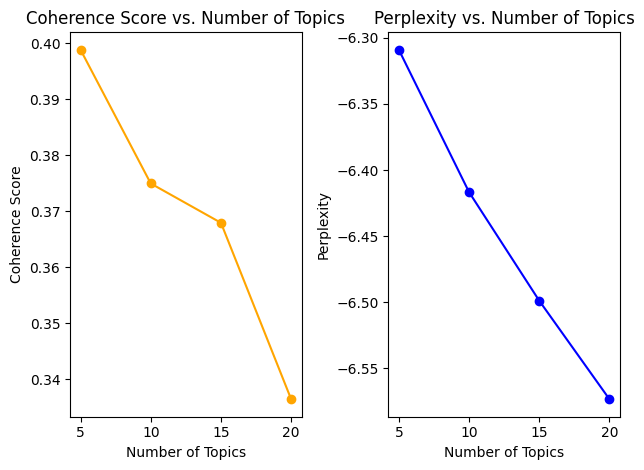

In [22]:
coherence_values = [0.3988187948305706, 0.3749336325685175, 0.3679081094298344, 0.33638455522641414]
perplexity_values = [-6.30900222593152, -6.4167284221793475, -6.498910621503642, -6.573444682722704]

# Plotting Coherence values
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_values, marker='o', color='orange')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')

# Plotting Perplexity values
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_values, marker='o', color='blue')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.tight_layout()

plt.show()

###Observations
- 5 Topics: The topics are broad and cover different aspects of customer experiences like service, food, class, and general customer complaints.
- 10 Topics: The topics become more specific, with more distinct themes around seating, delays, customer service issues, etc.
- 15 Topics: The topics start to fragment further, covering even more specific issues.
- 20 Topics: At this point, the topics become very granular, potentially losing coherence.

In [23]:
# Assuming lda_model is your trained LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

###Observations:

- Topic Distribution: The topics identified by the model show varying degrees of prevalence and similarity. Topic 2, being distinct and larger, suggests it covers a significant and unique portion of the corpus.

- Topic 2 Content: Topic 2 is characterized by terms related to airline experiences, with frequent mentions of "good," "crew," "food," and "cabin," indicating this topic likely pertains to general reviews or feedback about service quality on flights.

###Actionable Insighs:
- Focus on Improving Customer Service: Since Topic 3 is heavily centered around negative aspects of customer service, such as refunds and cancellations, it is essential for the airline to address these pain points.
- Improving the efficiency and customer experience in these areas could reduce the prevalence of this topic in future reviews, leading to better overall customer satisfaction.

In [24]:
# Assuming lda_model is your trained LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=8,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

###Observations:
- Topic 7 Focus: This topic seems to revolve around customer service issues, specifically related to problems with cancellations, refunds, bookings, and customer support interactions. The high relevance of terms like "cancelled," "refund," and "customer" suggests that this topic encapsulates discussions or complaints regarding these issues.
- Topic 6 Focus: This topic appears to revolve around seating issues or experiences, as indicated by the prominence of terms related to seats. Additionally, it may involve broader travel-related experiences, including those involving children or families.
- Topic 2 Focus: This topic is heavily centered on discussions related to different classes of airline service (business, economy, premium), as well as aspects of seating, cabin comfort, and food service. The prominence of this topic (22.9% of tokens) suggests that a large portion of customer feedback is focused on comparing and evaluating these aspects of the airline experience.
- Diversity of Topics: The spread of topics across the map suggests a wide range of issues being discussed in the reviews, from customer service to seating arrangements to overall passenger satisfaction.

###Actionable Insights:
- Service Improvements: The insights from Topic 6 could guide targeted improvements in seating arrangements, service differentiation between classes, and overall customer experience.
- Addressing Disparities: The clear distinction of Topic 6 might suggest a need to address specific disparities in the passenger experience between different classes, such as business vs. economy, particularly if negative sentiments are strong in this area